In [8]:
# !pip install cvlib
# !pip install -r requirements.txt
# !pip install tensorflow

In [5]:
import cv2
import pandas as pd
import cvlib as cv
import os 
from pathlib import Path
sys.path.append('/opt/ml/image-classification-level1-12/templates/pro_hun')
from utils.util import ensure_dir, prepare_device
from PIL import Image
import tqdm
import shutil

from utils.util import ensure_dir


def crop_coord(imagePath):
	image = cv2.imread(imagePath)
	face, confidence = cv.detect_face(image)
	if len(face)==0 :
		return 0
	x, y, w, h = face[0]
	coord = [x, y, w, h]

	return coord


def crop_face(coord_list, path, crop_path):
	if type(coord_list)==int:
		shutil.copy(path, crop_path)
		return
	x, y, w, h = coord_list
	image = cv2.imread(path)
	H, W, C = image.shape
	image_array = image[max(y-100,0):min(h+100,H), max(0,x-100):min(w+100,W)]
	cv2.imwrite(crop_path, image_array)

In [2]:
# train_with_label.csv에 추가 정보
label_path = '/opt/ml/image-classification-level1-12/templates/data/train/train_with_label.csv'
df = pd.read_csv(label_path)
df['normal'] = df['path'].map(lambda x: 1 if 'normal' in x else 0)
# crop_coor, 얼굴 좌표 반환
df['crop_coor'] = df.apply(lambda x: crop_coord(x['path']) if x['normal']==1 else None, axis=1)
df = df.sort_values(by='name').fillna(method='backfill', limit=6).sort_index()
# crop_image 저장할 경로 설정
# df['crop_path'] = df['path'].apply(lambda x: x.replace('images', 'image_crop'))
# # crop_image 생성
# df.apply(lambda x: crop_face(x['crop_coor'], x['path'], x['crop_path']), axis=1)
# # train_with_label에 crop_coord, crop_path 추가해서 재생성
# df.to_csv(label_path, index=False)

In [2]:
# Evalution Data에도 crop 적용
# image_crop 추가
eval_path = '/opt/ml/image-classification-level1-12/templates/data/eval'
eval_df = pd.read_csv(eval_path+'/info.csv')
eval_df['crop_coord'] = eval_df.apply(lambda x: crop_coord(eval_path+'/images/'+x['ImageID']),axis=1)

path = eval_path+'/images/'
crop_path = eval_path+'/crop_image/'

eval_df.apply(lambda x : crop_face(x['crop_coord'], path+x['ImageID'], crop_path+x['ImageID']), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
12595    None
12596    None
12597    None
12598    None
12599    None
Length: 12600, dtype: object

In [73]:
# train_with_crop.csv 생성
import pandas as pd

df = pd.read_csv('/opt/ml/image-classification-level1-12/templates/data/train/train_with_label.csv')
df_new = df[['crop_path', 'label']].copy()
df_new.columns = ['path', 'label']
# df_new = pd.DataFrame(df['path'].append(df['crop_path']), columns=['path'])
# df_new['label'] = df['label'].append(df['label'])
df_new['name'] = df_new['path'].apply(lambda x: x.split('/')[-2]+'_'+x.split('/')[-1])
df_new.to_csv('/opt/ml/image-classification-level1-12/templates/data/train/train_with_crop.csv', index=False)

In [16]:
# Original+Crop image folder
root_folder = '/opt/ml/image-classification-level1-12/templates/data/train/image_crop'
root_dir = [dir for dir in os.listdir(root_folder) if not dir.startswith('._')]
for folder_list in root_dir:
	crop_folder = os.path.join(root_folder, folder_list)
	move_folder = crop_folder.replace('image_crop', 'ori_crop')
	crop_dir = [dir for dir in os.listdir(crop_folder) if not dir.startswith('._')]	
	for image_list in crop_dir:
		shutil.copy(os.path.join(crop_folder, image_list), os.path.join(move_folder, 'crop'+image_list))

In [56]:
# Original+Crop 합친 csv 생성
df_label = pd.read_csv('/opt/ml/image-classification-level1-12/templates/data/train/train_with_label.csv')
df_crop = pd.read_csv('/opt/ml/image-classification-level1-12/templates/data/train/train_with_crop.csv')

label_series = df_label['path'].map(lambda x: x.replace('images', 'ori_crop'))
crop_series = df_crop['path'].map(lambda x: x.replace('image_crop', 'ori_crop'))
crop_series = crop_series.map(lambda x: "/".join(x.split('/')[:-1])+"/crop"+x.split('/')[-1])

df_merge = pd.DataFrame(label_series.append(crop_series), columns=['path'])
df_merge['label'] = df_label['label'].append(df_label['label'])
df_merge = df_merge.reset_index(drop=True)
df_merge['name'] = df_merge['path'].map(lambda x: x.split('/')[-2]+'_'+x.split('/')[-1])
df_merge.to_csv('/opt/ml/image-classification-level1-12/templates/data/train/train_with_all.csv', index=False)

In [12]:
# !pip install retina_face
# !pip install facenet-pytorch
# Crop 못한 eval_data Crop

from retinaface import RetinaFace
from facenet_pytorch import MTCNN
import pandas as pd
from tqdm.notebook import tqdm
from retinaface import RetinaFace

import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

workers = 0 if os.name == 'nt' else 4
print(workers)

remain_df = eval_df[eval_df['crop_coord']==0]
# make empty dataframe
df_eval_image = pd.DataFrame({})
cnt = 0 # intialize iteration count

# padding value before cropping
X_PADDING = 20 
Y_PADDING = 30 # gave more padding due to include mask on the chin & hair style

# initializing
cnt = 0
path = '/opt/ml/image-classification-level1-12/templates/data/eval/crop_image'

# iterating on test dataframe and marking detection points
for i in tqdm(remain_df.values):
  cnt += 1
  image_file_path = os.path.join(path,i[0])
  img = cv2.imread(image_file_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  boxes, probs, landmarks = mtcnn.detect(img, landmarks=True)
  # print(boxes, probs)
  
  # crop with mtcnn
  if probs[0]:
    xmin = int(boxes[0, 0]) - X_PADDING
    ymin = int(boxes[0, 1]) - Y_PADDING
    xmax = int(boxes[0, 2]) + X_PADDING
    ymax = int(boxes[0, 3]) + Y_PADDING
    
    # get landmark information
    left_eye = landmarks[0, 0]
    right_eye = landmarks[0, 1]
    mouth_left = landmarks[0, 2]
    mouth_right = landmarks[0, 3]
    nose = landmarks[0, 4]

  # when mtcnn fails,
  elif not probs[0]:
    result_detected = RetinaFace.detect_faces(image_file_path)

    # crop with retinaface
    if type(result_detected) == dict:
      print("resolving with retinaface: ", image_file_path)
      # save face bounding box information
      xmin = int(result_detected["face_1"]["facial_area"][0]) - X_PADDING
      ymin = int(result_detected["face_1"]["facial_area"][1]) - Y_PADDING
      xmax = int(result_detected["face_1"]["facial_area"][2]) + X_PADDING
      ymax = int(result_detected["face_1"]["facial_area"][3]) + Y_PADDING
      
      # save landmark information
      face_landmarks = result_detected["face_1"]["landmarks"]
      left_eye = face_landmarks["left_eye"]
      right_eye = face_landmarks["right_eye"]
      mouth_left = face_landmarks["mouth_left"]
      mouth_right = face_landmarks["mouth_right"]
      nose = face_landmarks["nose"]
    
    # retinaface fails, manually crop
    elif type(result_detected) == tuple:
      print("this one is causing trouble, manually cropped ", image_file_path)
      
      # xmin = 50
      # ymin = 100
      # xmax = 350
      # ymax = 400
      
      # coordination reference: https://stages.ai/competitions/74/discussion/talk/post/516

      xmin = 80
      ymin = 50
      xmax = 80 + 220
      ymax = 50 + 320

      
      face_landmarks = left_eye = right_eye = np.nan
      mouth_left = mouth_right = nose = np.nan

  # prevent tile out of box error
  if xmin<0:xmin=0
  if ymin<0:ymin=0
  if xmax>384:xmax=384
  if ymax>512:ymax=512
  
  # add row to the df_eval_images with the extracted information
  df_eval_image = df_eval_image.append(
    {
      "ImageID":i[0],
      "ans":0,
      "xmin": xmin,
      "ymin": ymin,
      "xmax": xmax,
      "ymax": ymax,
      "left_eye": left_eye,
      "right_eye": right_eye,
      "mouth_left": mouth_left,
      "mouth_right": mouth_right,
      "nose": nose
    }, ignore_index=True)

  # print data information every 100 iterations
  if cnt % 100 == 0:
    print(df_eval_image.shape)
    print(df_eval_image.info())
    print(df_eval_image.tail())

4


  0%|          | 0/284 [00:00<?, ?it/s]

resolving with retinaface:  /opt/ml/image-classification-level1-12/templates/data/eval/crop_image/e8edccf26199d6ad0371e14755ec094a0c1f99f0.jpg
resolving with retinaface:  /opt/ml/image-classification-level1-12/templates/data/eval/crop_image/fa989be2a170b82cee7aeda979d08d813009fd90.jpg
resolving with retinaface:  /opt/ml/image-classification-level1-12/templates/data/eval/crop_image/1d9101c7c4e53ca016924f470a3280c54f7e7125.jpg
resolving with retinaface:  /opt/ml/image-classification-level1-12/templates/data/eval/crop_image/f3d2965a841600cca7d0c932c0e9fe05562fb24d.jpg
resolving with retinaface:  /opt/ml/image-classification-level1-12/templates/data/eval/crop_image/0c9c32ff76b7e3b547509e7010910db3dca6f23c.jpg
resolving with retinaface:  /opt/ml/image-classification-level1-12/templates/data/eval/crop_image/53b00dad7c7225ca7bba3c43b8b73db5f1a0c05d.jpg
resolving with retinaface:  /opt/ml/image-classification-level1-12/templates/data/eval/crop_image/4e892336512df1c0e679c706a8073fd0aecbf80d.jpg

In [3]:
df_eval_image['crop_coord'] = df_eval_image.apply(lambda x: [x['xmin'], x['ymin'], x['xmax'], x['ymax']],axis=1)
df_eval_image['crop_coord'] = df_eval_image['crop_coord'].apply(lambda x:[int(i) for i in x])
path = eval_path+'/images/'
crop_path = eval_path+'/crop_image/'

# df_eval_image.apply(lambda x : crop_face(x['crop_coord'], path+x['ImageID'], crop_path+x['ImageID']), axis=1)

NameError: name 'df_eval_image' is not defined

In [75]:
df_eval_image

,ImageID,ans,left_eye,mouth_left,mouth_right,nose,right_eye,xmax,xmin,ymax,ymin,crop_coord
0,4702037fc73744daef1a4a6253895886f86808b8.jpg,0.0,"[163.15512, 228.69907]","[198.82283, 257.66458]","[174.19768, 288.98752]","[224.39444, 284.66443]","[226.07085, 221.93443]",272.0,105.0,350.0,133.0,"[105, 133, 272, 350]"
1,e7d4a815cbf2dd60aaf5f764be67f656cf7e5b19.jpg,0.0,"[180.56253, 212.88553]","[223.60843, 261.9182]","[181.42422, 304.61932]","[261.65796, 307.08905]","[272.2229, 211.39777]",351.0,82.0,413.0,80.0,"[82, 80, 351, 413]"
2,d465ebee7f2ea57529fbf5503bf1ad42024ac3d2.jpg,0.0,"[171.51965, 221.27615]","[196.00363, 244.35245]","[173.67259, 278.99548]","[217.97498, 281.05457]","[227.83139, 222.8831]",272.0,114.0,346.0,137.0,"[114, 137, 272, 346]"
3,002fa45ccbee3dd31f84e3fc916906796318600c.jpg,0.0,"[172.51239, 191.41324]","[207.58328, 247.65852]","[175.48381, 285.33167]","[253.87222, 287.68823]","[261.4743, 193.64206]",345.0,104.0,364.0,58.0,"[104, 58, 345, 364]"
4,2e808fe6daf8c596480f34c0c5372d094c01acd5.jpg,0.0,"[163.1732, 226.14381]","[183.39058, 245.5882]","[171.68332, 274.536]","[208.38223, 271.02393]","[210.67361, 219.98776]",262.0,113.0,333.0,144.0,"[113, 144, 262, 333]"
...,...,...,...,...,...,...,...,...,...,...,...,...
279,b628a7e0b9d90bd7f57c03a2ec43da095abdc266.jpg,0.0,"[175.15256, 217.83603]","[211.05765, 239.9925]","[185.8133, 283.81354]","[235.92966, 282.19943]","[233.35406, 215.05383]",289.0,101.0,373.0,131.0,"[101, 131, 289, 373]"
280,20eb40e5937d6478a1e1f44f441a728dedb98f8a.jpg,0.0,"[166.50194, 237.66895]","[194.10791, 266.24588]","[165.1275, 303.90543]","[222.00888, 307.20438]","[231.5226, 240.28903]",286.0,106.0,378.0,145.0,"[106, 145, 286, 378]"
281,f121911d5e8c32ce8a9565f72a2ecc497c07c052.jpg,0.0,"[207.09747, 234.31581]","[199.74751, 297.90353]","[153.2222, 302.49152]","[173.11539, 261.58237]","[143.46779, 239.00117]",267.0,91.0,370.0,145.0,"[91, 145, 267, 370]"
282,d1d7f58b124182e10c7a22f26c0861587f9ada2a.jpg,0.0,"[156.06879, 225.17856]","[206.5635, 276.3014]","[166.30554, 325.86523]","[254.45584, 322.76733]","[257.21295, 217.63492]",329.0,79.0,411.0,105.0,"[79, 105, 329, 411]"


In [85]:
remain_df.values[0][0]

'4702037fc73744daef1a4a6253895886f86808b8.jpg'

  0%|          | 0/284 [00:00<?, ?it/s]

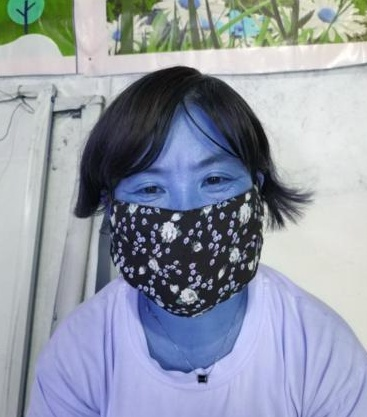

  0%|          | 1/284 [00:00<00:39,  7.10it/s]

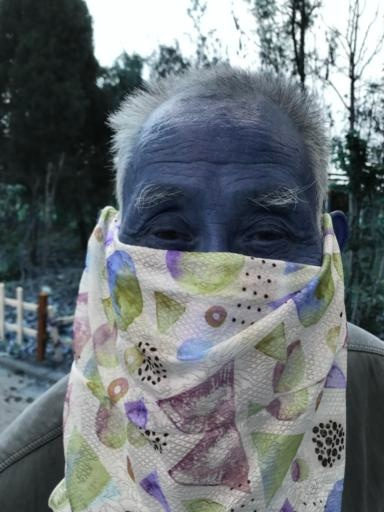

  1%|          | 2/284 [00:00<00:43,  6.51it/s]

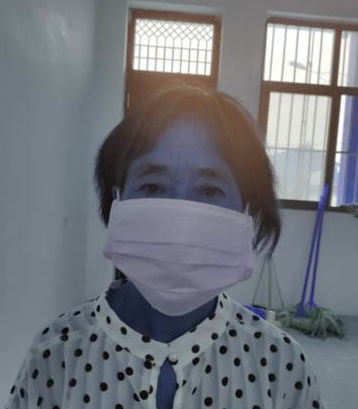

  1%|          | 3/284 [00:00<00:38,  7.36it/s]

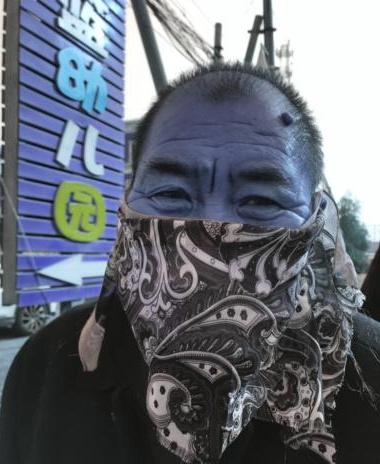

  1%|▏         | 4/284 [00:00<00:36,  7.58it/s]

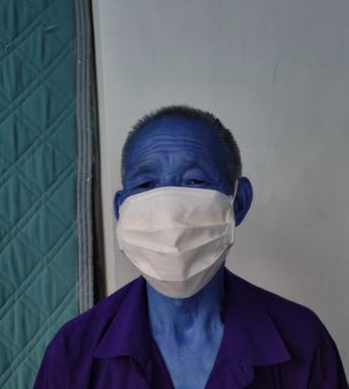

  2%|▏         | 5/284 [00:00<00:33,  8.26it/s]

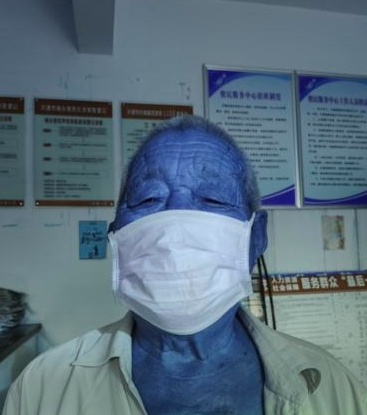

  2%|▏         | 6/284 [00:00<00:34,  8.15it/s]

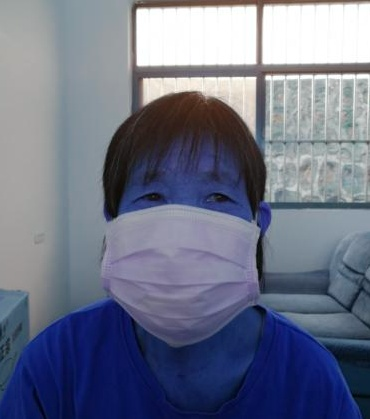

  2%|▏         | 7/284 [00:00<00:34,  7.95it/s]

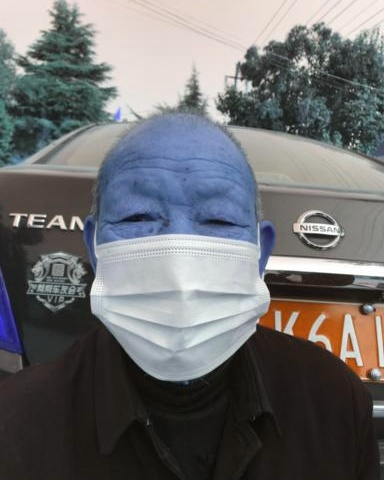

  3%|▎         | 8/284 [00:01<00:35,  7.81it/s]

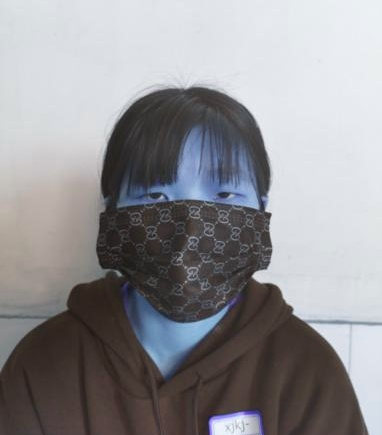

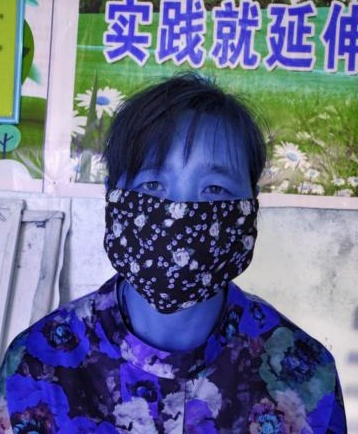

  4%|▎         | 10/284 [00:01<00:32,  8.47it/s]

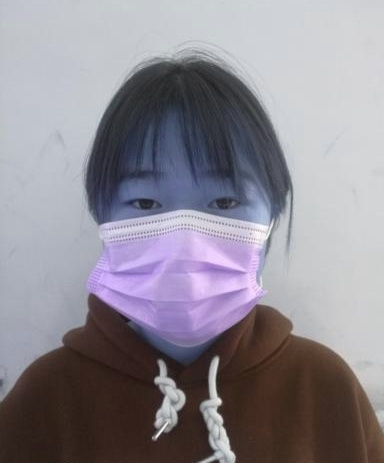

  4%|▍         | 11/284 [00:01<00:30,  8.81it/s]

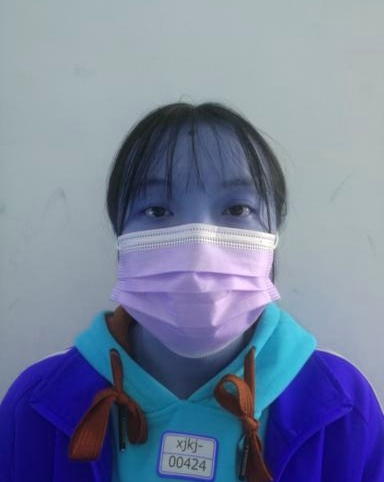

In [6]:
remain_df = eval_df[eval_df['crop_coord']==0]
eval_path = '/opt/ml/image-classification-level1-12/templates/data/eval'
crop_path = eval_path+'/crop_image/'
for i in tqdm.tqdm(remain_df.values):
    # cnt += 1
    image_file_path = os.path.join(crop_path,i[0])
    img = cv2.imread(image_file_path)
    pil_image=Image.fromarray(img)
    pil_image.show()
